In [ ]:
# 0_ingest_epc.py
import os, re, glob, sys, pandas as pd
from collections import defaultdict

sys.path.insert(0, os.path.abspath(".."))
from src.preprocess import split_improvements, parse_improvement, clean_text
from src.labels import labels_measure

DATA_ROOT = "../data/raw"
CSV_GLOB  = os.path.join(DATA_ROOT, "D_EPC_data_*", "*.csv")
ID_COL, TEXT_COL = "REPORT_REFERENCE_NUMBER", "IMPROVEMENTS"
CHUNKSIZE = 50_000
OUTPUT_CSV = "../data/processed/epc_property_level.csv"

period_re = re.compile(r"(?<!\d)(\d{4})Q([1-4])(?!\d)")
def infer_period_from_path(path: str) -> str:
    fn = os.path.basename(path)
    m  = period_re.search(fn)
    if m: return m.group(0)
    matches = list(period_re.finditer(path))
    return matches[-1].group(0) if matches else "UNKNOWN"

prop_texts, prop_labels, prop_periods = defaultdict(list), defaultdict(set), defaultdict(set)

all_csvs = sorted(glob.glob(CSV_GLOB))
print(f"Found {len(all_csvs)} CSV files")

files_seen = rows_seen = segs_seen = measures_ok = labels_added = 0

for fpath in all_csvs:
    files_seen += 1
    period = infer_period_from_path(fpath)
    print(f"Reading: {fpath} (period {period})")
    reader = pd.read_csv(fpath, chunksize=CHUNKSIZE, low_memory=False, usecols=[ID_COL, TEXT_COL])

    for chunk in reader:
        for rrn, txt in chunk[[ID_COL, TEXT_COL]].itertuples(index=False, name=None):
            if pd.isna(txt): 
                continue
            rows_seen += 1
            for seg in split_improvements(txt):
                segs_seen += 1
                rec = parse_improvement(seg)
                m = rec.get("measure") if isinstance(rec, dict) else None
                if not m: 
                    # fallback: if your parser misses it, keep raw seg
                    m = seg
                prop_texts[rrn].append(m)
                L = labels_measure(m)
                prop_labels[rrn] |= L
                labels_added += len(L)
                prop_periods[rrn].add(period)
                measures_ok += 1
    # if files_seen % 20 == 0:
    #     print(f"  ... processed {files_seen} files, {rows_seen:,} rows, {segs_seen:,} segments, {measures_ok:,} measures")
    #     break

rows = []
for rrn, measures in prop_texts.items():
    labs = sorted(list(prop_labels[rrn]))
    if not labs: 
        continue
    periods_sorted = sorted(p for p in prop_periods[rrn] if p != "UNKNOWN") or ["UNKNOWN"]
    rows.append({
        "rrn": rrn,
        "text_raw": " . ".join(measures),
        "labels": labs,
        "periods": periods_sorted,
        "n_periods": len(periods_sorted),
        "n_measures": len(measures),
    })

prop_df = pd.DataFrame(rows, columns=["rrn","text_raw","labels","periods","n_periods","n_measures"])
prop_df["text_clean"] = prop_df["text_raw"].map(clean_text)

os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
prop_df.to_csv(OUTPUT_CSV, index=False)

print("\n--- Ingestion summary ---")
print(f"Files read:            {files_seen}")
print(f"Rows with text:        {rows_seen:,}")
print(f"Segments split:        {segs_seen:,}")
print(f"Measures kept:         {measures_ok:,}")
print(f"Labels assigned:       {labels_added:,}")
print(f"Properties (rows):     {len(prop_df):,}")
print(f"Saved -> {OUTPUT_CSV}")


Found 40 CSV files
Reading: ../data/raw/D_EPC_data_2025Q2/2015Q3.csv (period 2015Q3)
Reading: ../data/raw/D_EPC_data_2025Q2/2015Q4.csv (period 2015Q4)
Reading: ../data/raw/D_EPC_data_2025Q2/2016Q1.csv (period 2016Q1)
Reading: ../data/raw/D_EPC_data_2025Q2/2016Q2.csv (period 2016Q2)
Reading: ../data/raw/D_EPC_data_2025Q2/2016Q3.csv (period 2016Q3)
Reading: ../data/raw/D_EPC_data_2025Q2/2016Q4.csv (period 2016Q4)
Reading: ../data/raw/D_EPC_data_2025Q2/2017Q1.csv (period 2017Q1)
Reading: ../data/raw/D_EPC_data_2025Q2/2017Q2.csv (period 2017Q2)
Reading: ../data/raw/D_EPC_data_2025Q2/2017Q3.csv (period 2017Q3)
Reading: ../data/raw/D_EPC_data_2025Q2/2017Q4.csv (period 2017Q4)
Reading: ../data/raw/D_EPC_data_2025Q2/2018Q1.csv (period 2018Q1)
Reading: ../data/raw/D_EPC_data_2025Q2/2018Q2.csv (period 2018Q2)
Reading: ../data/raw/D_EPC_data_2025Q2/2018Q3.csv (period 2018Q3)
Reading: ../data/raw/D_EPC_data_2025Q2/2018Q4.csv (period 2018Q4)
Reading: ../data/raw/D_EPC_data_2025Q2/2019Q1.csv (period

In [18]:
#Sanity check 
print(prop_df['text_raw'].iloc[0])
print(prop_df['text_clean'].iloc[0])

Solar photovoltaic panels, 2.5 kWp . Replace boiler with new condensing boiler . Floor insulation (suspended floor) . Low energy lighting for all fixed outlets . Solar water heating . Internal or external wall insulation
solar photovoltaic panels kwp replace boiler new condensing boiler floor insulation suspended floor low energy lighting fixed outlets solar water heating internal external wall insulation


In [19]:
# 1_prepare_labels.py
import ast, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

prop_df = pd.read_csv(
    "../data/processed/epc_property_level.csv",
    converters={
        "labels":  lambda s: ast.literal_eval(s) if pd.notna(s) else [],
        "periods": lambda s: ast.literal_eval(s) if pd.notna(s) else [],
    },
)

# Optional subset during iteration
sub = prop_df.sample(n=min(len(prop_df), 200_000), random_state=42).reset_index(drop=True)

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(sub["labels"])
print("Classes:", mlb.classes_)  # -> ['glazing','heating','hot_water','insulation','lighting','renewables']

train_df, test_df, Y_train, Y_test = train_test_split(
    sub[["text_clean"]], Y, test_size=0.15, random_state=42
)

# Save mlb for inference
import joblib, os
os.makedirs("../models", exist_ok=True)
joblib.dump(mlb, "../models/mlb.joblib")



Classes: ['glazing' 'heating' 'hot_water' 'insulation' 'lighting' 'renewables']


['../models/mlb.joblib']

In [20]:
# 2_train_transformer.py
import numpy as np, torch, pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.metrics import f1_score, jaccard_score, hamming_loss
import joblib

# Inputs from previous step
mlb = joblib.load("../models/mlb.joblib")
num_labels = len(mlb.classes_)
train_ds = Dataset.from_pandas(pd.DataFrame({"text": train_df["text_clean"], "labels": list(Y_train)}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": test_df["text_clean"],  "labels": list(Y_test)}))

MODEL_NAME = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=256)

train_tok = train_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

# Set format for PyTorch
cols = ["input_ids","attention_mask","labels"]
train_tok = train_tok.rename_column("labels","labels_raw")
test_tok  = test_tok.rename_column("labels","labels_raw")
def to_torch(batch):
    batch["labels"] = torch.tensor(batch["labels_raw"], dtype=torch.float)
    return batch
train_tok = train_tok.map(to_torch, batched=True, remove_columns=set(train_tok.column_names)-set(["input_ids","attention_mask","labels","text"]))
test_tok  = test_tok.map(to_torch,  batched=True, remove_columns=set(test_tok.column_names)-set(["input_ids","attention_mask","labels","text"]))
train_tok.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_tok.set_format("torch",  columns=["input_ids","attention_mask","labels"])

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # sets BCEWithLogitsLoss
)

def sigmoid(x): 
    return 1/(1+np.exp(-x))

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_true = np.array(y_true, dtype=int)
    y_prob = sigmoid(logits)
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "jaccard_samples": jaccard_score(y_true, y_pred, average="samples"),
        "hamming_loss": hamming_loss(y_true, y_pred),
    }

args = TrainingArguments(
    output_dir="../models/epc_distilbert_multilabel",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,   # (use a true val split if you have one)
    tokenizer=tok,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_out = trainer.train()
trainer.save_model("../models/epc_distilbert_multilabel/best")
tok.save_pretrained("../models/epc_distilbert_multilabel/best")




Map: 100%|██████████| 30000/30000 [00:00<00:00, 101730.65 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2129/164143967.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Jaccard Samples,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.007800,0.000018,1.000000,1.000000,1.000000,0.000000,47.610800,630.110000,19.701000


('../models/epc_distilbert_multilabel/best/tokenizer_config.json',
 '../models/epc_distilbert_multilabel/best/special_tokens_map.json',
 '../models/epc_distilbert_multilabel/best/vocab.txt',
 '../models/epc_distilbert_multilabel/best/added_tokens.json',
 '../models/epc_distilbert_multilabel/best/tokenizer.json')

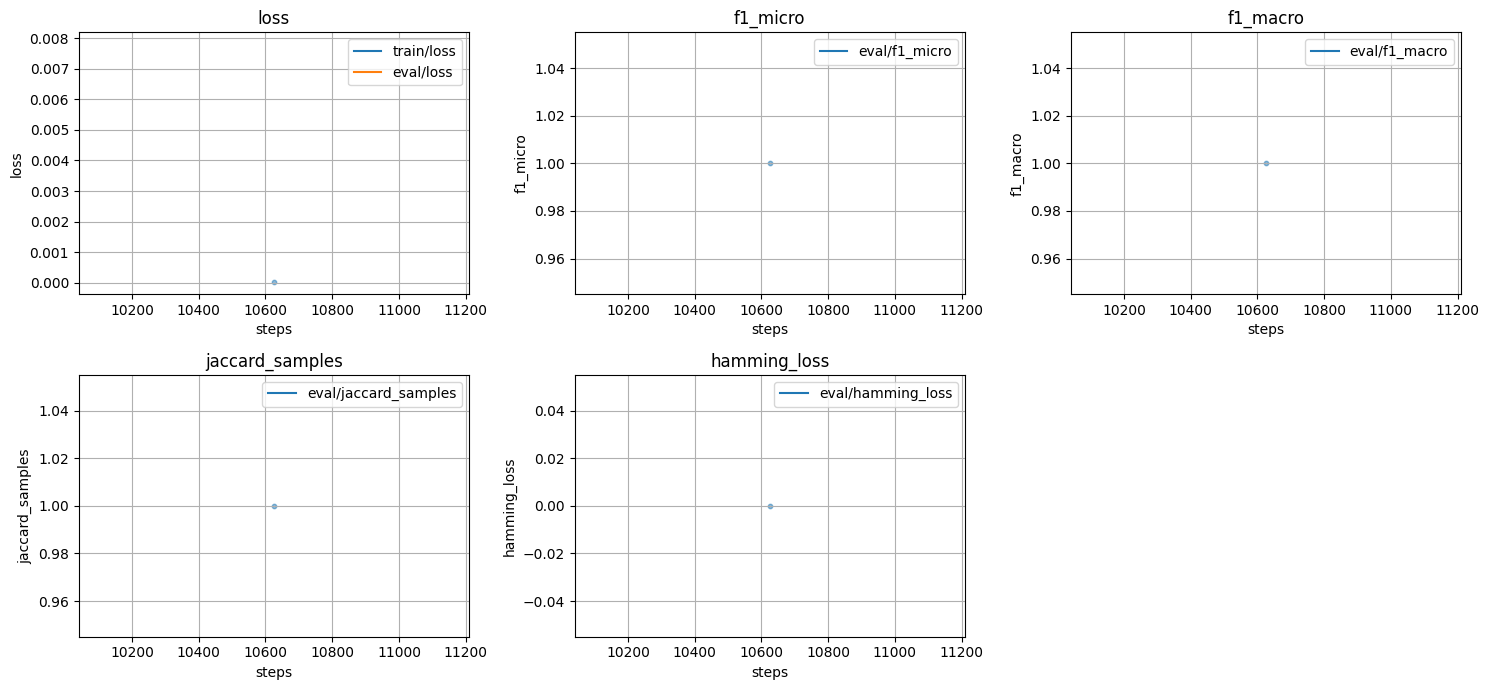

In [21]:
# 3_plot_logs.py
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt

logs = trainer.state.log_history
rows = []
for r in logs:
    step = r.get("step")
    if step is None: 
        continue
    if "loss" in r:
        rows.append({"step": step, "split": "train", "metric": "loss", "value": r["loss"]})
    for k, v in r.items():
        if k.startswith("eval_"):
            rows.append({"step": step, "split": "eval", "metric": k.replace("eval_",""), "value": v})
df = pd.DataFrame(rows)
if df.empty:
    print("No metrics found in log_history"); 
else:
    def smooth(s, w=5): return s.rolling(window=w, min_periods=1).mean()
    metrics = ["loss","f1_micro","f1_macro","jaccard_samples","hamming_loss"]
    metrics = [m for m in metrics if m in df["metric"].unique()]
    n, cols = len(metrics), 3
    r = math.ceil(n/cols)
    fig, axes = plt.subplots(r, cols, figsize=(5*cols,3.5*r)); axes = axes.flatten()
    for i, m in enumerate(metrics):
        ax = axes[i]
        if m=="loss":
            dtr = df[(df.metric=="loss")&(df.split=="train")].sort_values("step")
            if not dtr.empty: ax.plot(dtr["step"], smooth(dtr["value"],7), label="train/loss")
        dev = df[(df.metric==m)&(df.split=="eval")].sort_values("step")
        if not dev.empty:
            ax.plot(dev["step"], smooth(dev["value"],3), label=f"eval/{m}")
            ax.scatter(dev["step"], dev["value"], s=10, alpha=0.5)
        ax.set_title(m); ax.set_xlabel("steps"); ax.set_ylabel(m); ax.grid(True); ax.legend()
    for j in range(i+1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()


In [22]:
from sklearn.metrics import jaccard_score

pred = trainer.predict(test_tok)
y_true = np.array(pred.label_ids).astype(int)
y_prob = 1/(1+np.exp(-pred.predictions))

ts = np.linspace(0.2, 0.8, 13)
best_t = ts[np.argmax([jaccard_score(y_true, (y_prob>=t).astype(int), average="samples") for t in ts])]
y_pred = (y_prob >= best_t).astype(int)
print("Best threshold:", best_t)


Best threshold: 0.2


In [23]:
mlb.classes_

array(['glazing', 'heating', 'hot_water', 'insulation', 'lighting',
       'renewables'], dtype=object)

In [24]:
from sklearn.metrics import f1_score, jaccard_score, hamming_loss, classification_report
import numpy as np

# assuming you still have y_true and y_prob from predict()
t = 0.25
y_pred = (y_prob >= t).astype(int)

print("Hamming loss (more better):", hamming_loss(y_true, y_pred))
print("Jaccard (samples avg, more better):", jaccard_score(y_true, y_pred, average="samples"))
print("F1 micro:", f1_score(y_true, y_pred, average="micro", zero_division=0))
print("F1 macro:", f1_score(y_true, y_pred, average="macro", zero_division=0))

# per-class report
print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))
y_pred_safe = y_pred.copy()
empty = y_pred_safe.sum(axis=1) == 0
top1 = y_prob[empty].argmax(axis=1)
y_pred_safe[empty, top1] = 1


Hamming loss (more better): 0.0
Jaccard (samples avg, more better): 1.0
F1 micro: 1.0
F1 macro: 1.0
              precision    recall  f1-score   support

     glazing       1.00      1.00      1.00      4883
     heating       1.00      1.00      1.00     12314
   hot_water       1.00      1.00      1.00      3581
  insulation       1.00      1.00      1.00     21777
    lighting       1.00      1.00      1.00     17950
  renewables       1.00      1.00      1.00     18167

   micro avg       1.00      1.00      1.00     78672
   macro avg       1.00      1.00      1.00     78672
weighted avg       1.00      1.00      1.00     78672
 samples avg       1.00      1.00      1.00     78672



In [25]:
mlb.classes_

array(['glazing', 'heating', 'hot_water', 'insulation', 'lighting',
       'renewables'], dtype=object)

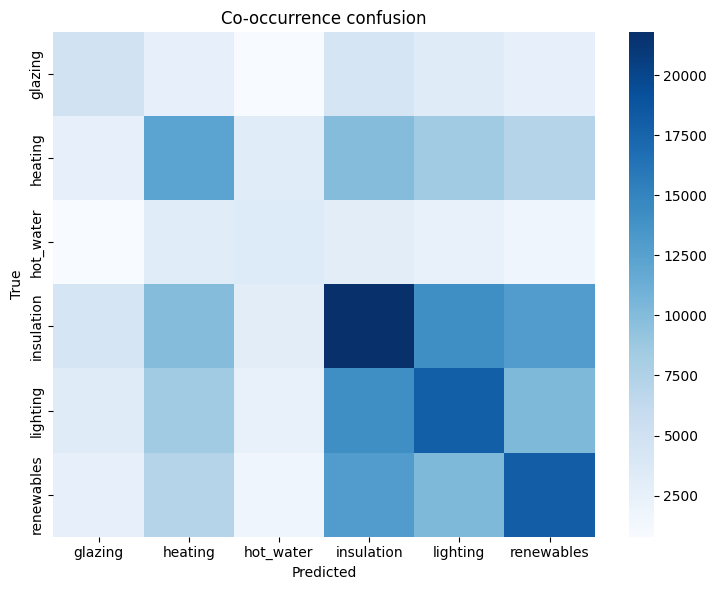

In [26]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np

cooc = np.zeros((len(mlb.classes_), len(mlb.classes_)), dtype=int)
for yt, yp in zip(y_true, y_pred):
    t_idx, p_idx = np.where(yt==1)[0], np.where(yp==1)[0]
    for t_i in t_idx:
        for p_i in p_idx:
            cooc[t_i, p_i] += 1

plt.figure(figsize=(7.5,6))
sns.heatmap(cooc, cmap="Blues", xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Co-occurrence confusion"); plt.tight_layout(); plt.show()


In [29]:
# 4_infer.py
import torch, numpy as np, pandas as pd, joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification

mlb = joblib.load("../models/mlb.joblib")
tok = AutoTokenizer.from_pretrained("../models/epc_distilbert_multilabel/best")
model = AutoModelForSequenceClassification.from_pretrained("../models/epc_distilbert_multilabel/best")
model.eval()

def predict_labels(texts, model, tokenizer, mlb, threshold=0.5, batch_size=64, return_df=True):
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, (pd.Series, np.ndarray)):
        texts = pd.Series(texts).astype(str).tolist()
    else:
        texts = [str(t) for t in texts]

    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        toks = tokenizer(batch, truncation=True, padding=True, return_tensors="pt").to(model.device)
        with torch.no_grad():
            probs = torch.sigmoid(model(**toks).logits).cpu().numpy()
        for txt, p in zip(batch, probs):
            label_probs = dict(zip(mlb.classes_.tolist(), p.tolist()))
            predicted = [lbl for lbl, val in label_probs.items() if val >= threshold]
            results.append({"text": txt, "predicted": predicted, **{f"p_{k}": float(v) for k,v in label_probs.items()}})
    return pd.DataFrame(results) if return_df else results

sample_all = (
    "Install double glazing on all windows, add loft and cavity wall insulation. ",
    "Replace the old boiler with a high-efficiency condensing heating system, ",
    "upgrade the hot water cylinder, fit low-energy LED lighting throughout, ",
    "and add solar panels as a renewable energy source.",
)
df_pred = predict_labels(
    sample_all,
    model, tok, mlb, threshold=0.5
)
print(df_pred[["text","predicted"]])


                                                text  \
0  Install double glazing on all windows, add lof...   
1  Replace the old boiler with a high-efficiency ...   
2  upgrade the hot water cylinder, fit low-energy...   
3  and add solar panels as a renewable energy sou...   

                        predicted  
0                    [insulation]  
1                       [heating]  
2  [heating, hot_water, lighting]  
3                    [renewables]  


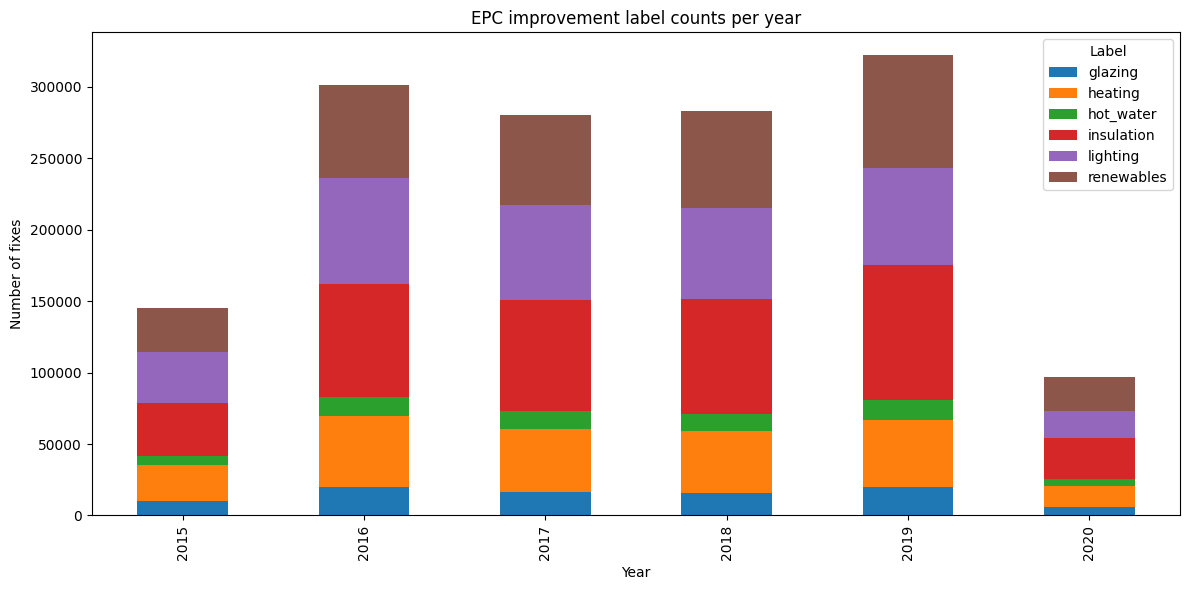

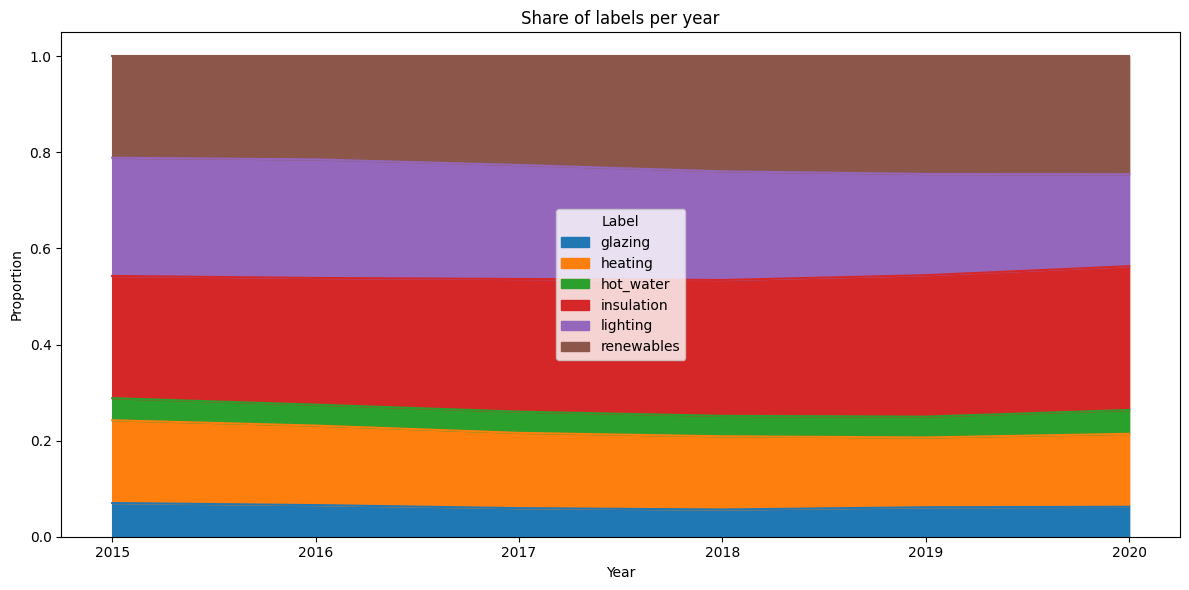

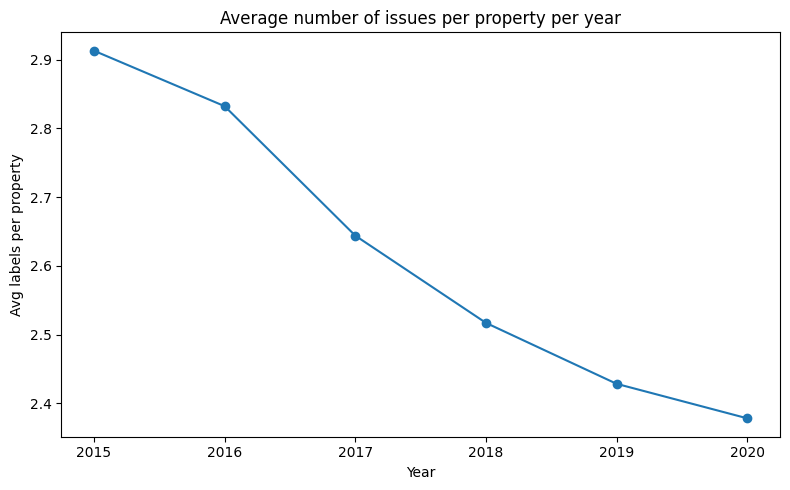

In [28]:
# 5_eco_trends.py
import ast, pandas as pd, matplotlib.pyplot as plt

prop_df = pd.read_csv(
    "../data/processed/epc_property_level.csv",
    converters={"labels":  lambda s: ast.literal_eval(s) if pd.notna(s) else [],
                "periods": lambda s: ast.literal_eval(s) if pd.notna(s) else []},
)
df = prop_df.explode("periods").explode("labels").reset_index(drop=True)
df["year"] = df["periods"].str.slice(0,4)

# counts per label per year
label_counts = (df.groupby(["year","labels"])
                  .size().reset_index(name="count")
                  .sort_values(["year","labels"]))
pivot_counts = label_counts.pivot(index="year", columns="labels", values="count").fillna(0)

# share per label per year
pivot_share = pivot_counts.div(pivot_counts.sum(axis=1), axis=0).fillna(0)

# average number of issues per property per year
problems_per_prop = (df.groupby(["year","rrn"])["labels"].nunique()
                       .reset_index(name="n_labels"))
avg_problems = (problems_per_prop.groupby("year")["n_labels"]
                  .mean().reset_index(name="avg_labels_per_property"))

# plots
plt.figure(figsize=(12,6))
pivot_counts.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("EPC improvement label counts per year")
plt.ylabel("Number of fixes"); plt.xlabel("Year"); plt.legend(title="Label"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,6))
pivot_share.plot(kind="area", ax=plt.gca())
plt.title("Share of labels per year"); plt.ylabel("Proportion"); plt.xlabel("Year")
plt.legend(title="Label"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(avg_problems["year"], avg_problems["avg_labels_per_property"], marker="o")
plt.title("Average number of issues per property per year")
plt.ylabel("Avg labels per property"); plt.xlabel("Year"); plt.tight_layout(); plt.show()
